[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiptos/is_notes/blob/main/lstm.ipynb)

# Text Classification using LSTM

## Import libraries

First, it is necessary to import the required libraries.

In [3]:
import pandas as pd
from collections import Counter
from functools import partial
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torchtext.data.utils import get_tokenizer
from nltk.corpus import stopwords
from torch import nn, optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data.dataset import random_split

tqdm.pandas()

## Download the dataset and select a subset of it

The dataset is big, composed of more than 4 million records. Let's download it and process it to retrieve a smaller sample.

In [4]:
df = pd.read_csv('https://files.consumerfinance.gov/ccdb/complaints.csv.zip', dtype='str')

Remove all the records that have wither empty label (`Product`) or content (`Consumer complaint narrative`)

In [5]:
print(df.shape)
df_nonan = df[df['Consumer complaint narrative'].notna() & df['Product'].notna()]
print(df_nonan.shape)

(6878550, 18)
(2301581, 18)


Select 100000 random samples

In [6]:
sample = df_nonan.sample(n=100000, ignore_index=True)
sample = sample[["Product", "Consumer complaint narrative"]]
print(sample.shape)

(100000, 2)


Check the full set of labels

In [8]:
sample.Product.value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    35131
Credit reporting or other personal consumer reports                             25478
Debt collection                                                                 12740
Mortgage                                                                         5285
Credit card or prepaid card                                                      4715
Checking or savings account                                                      4676
Credit card                                                                      2526
Student loan                                                                     2043
Money transfer, virtual currency, or money service                               1922
Vehicle loan or lease                                                            1545
Credit reporting                                                                 1436
Payday loan, title loan, or personal loan     

## Consolidate labels

There are some categories (labels) that have simillar meaning or context. Let's unify them, thus reducing the number of classes.

In [9]:
sample.loc[sample[
               'Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
sample.loc[sample[
               'Product'] == 'Credit reporting or other personal consumer reports', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
sample.loc[sample['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
sample.loc[sample['Product'] == 'Prepaid card', 'Product'] = 'Credit card or prepaid card'
sample.loc[sample['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
sample.loc[sample['Product'] == 'Vehicle loan or lease', 'Product'] = 'Payday loan, title loan, or personal loan'
sample.loc[sample['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
sample = sample[sample.Product != 'Other financial service']

In [10]:
sample.Product.value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    62045
Debt collection                                                                 12740
Credit card or prepaid card                                                      7472
Mortgage                                                                         5285
Checking or savings account                                                      4676
Payday loan, title loan, or personal loan                                        2365
Student loan                                                                     2043
Money transfer, virtual currency, or money service                               1922
Bank account or service                                                           670
Consumer Loan                                                                     383
Payday loan, title loan, personal loan, or advance loan                           241
Money transfers                               

<Axes: title={'center': 'Number complaints in each product'}, xlabel='Product'>

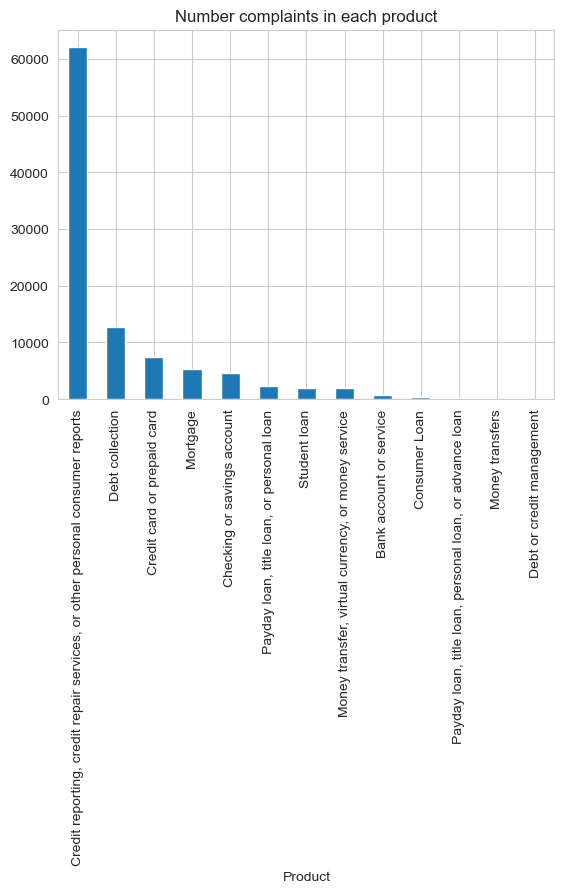

In [11]:
sample['Product'].value_counts().sort_values(ascending=False).plot(kind='bar',
                                                                   title='Number complaints in each product')

## Save the current dataset

So that we don't need to do the same process again... we can start from the **Text Processing** section, after this.

In [12]:
sample.to_pickle("sample.pkl")

# Text Preprocessing

Let's start by reading the dataset sample, saved previously.

In [13]:
sample = pd.read_pickle("sample.pkl")

As an example, let's print two records.

In [15]:
def print_plot(index):
    example = sample[sample.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])


print_plot(10)
print("-----------")
print_plot(88)

I contacted the company to cancel my trip and was told I needed to contact the merchant XXXX XXXX to make that cancel request and that merchant would notify them ( XXXX ). I followed XXXX advised and made contact with XXXX XXXX to cancel my trip, they cancelled my trip ( confirmation code XXXX  ) on XXXX/XXXX/2924 at XXXX XXXX. At that point I thought everything was final due to what XXXX advised me to do, but then they withdrew XXXX additional payments out of my banking account. I made contact with XXXX at that time to see what was going on and they refused to cancel my loan when I provided them the cancellation information and proceeded to harrass me with threatening phone calls and emails. XXXX then lied reporting false information to the credit bureau in error causing me to drop my credit score by XXXX points. I want them investigated for reporting false information and have them reverse what was reported.
Product: Credit reporting, credit repair services, or other personal consume

Replace the text label for a number, so that we have a numeric representation of the classes.

In [17]:
sample.Product = pd.Categorical(sample.Product)
codes, unique = pd.factorize(sample.Product)
sample.Product = codes
sample

,Product,Consumer complaint narrative
0,0,Ive been contacting the credit bureaus for 9 m...
1,0,Im begging you please remove this to the credi...
2,0,Hey Hope all is well. I was looking through my...
3,0,( a ) BlockExcept as otherwise provided in thi...
4,1,I have been pa ying {$360.00} a month for near...
...,...,...
99995,0,There is a XXXX XXXX card listed as a charge o...
99996,0,I never gave Experian my written consent to pu...
99997,0,Starting in the summer of XXXX I called XXXX X...
99998,0,I've found that my credit report has erroneous...


# LSTM Model

Now we can start working towards the design and development of an LSTM model for classification.

Let's start by creating the `Dataset` class able to interpret, clean and convert the text.

In [18]:
import re
import nltk
from nltk import WordNetLemmatizer
nltk.download('stopwords')
!pip install -U pywsd
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
sample = sample.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    # lowercase text
    text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    new_sent = ''
    for word in text.split():
        # Remove stop words
        if word not in STOPWORDS:
            # Lemmatize
            word = lemmatizer.lemmatize(word)
            new_sent = new_sent + ' ' + word
    text = new_sent
    return text


def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens
            else '<unk>' for token in tokens][-max_len:]


def tokenize(text, stop_words):
    tokenizer = get_tokenizer("basic_english")
    tokens = tokenizer(text)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens


class DataFrameTextDataset(Dataset):
    def __init__(self, text: list, label: list, max_vocab, max_len):
        df = pd.DataFrame(list(zip(text, label)), columns=['text', 'label'])

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        df.text = df.text.progress_apply(clean_text)
        df.text = df.text.str.replace('\d+', '')
        df['tokens'] = df.text.progress_apply(partial(tokenize, stop_words=stop_words))

        # Replace rare words with <unk>
        all_tokens = [sublst for lst in df.tokens.tolist() for sublst in lst]
        common_tokens = set(list(zip(*Counter(all_tokens).most_common(max_vocab)))[0])
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(remove_rare_words, common_tokens=common_tokens, max_len=max_len))

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(lambda tokens: any(token != '<unk>' for token in tokens))]

        vocab = sorted({sublst for lst in df.tokens.tolist() for sublst in lst})
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}

        # Add a padding idx
        self.token2idx['<pad>'] = max(self.token2idx.values()) + 1

        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

        df.loc[:, 'indexed_tokens'] = df.loc[:, 'tokens'].apply(
            lambda tokens: [self.token2idx[token] for token in tokens])
        self.text = df.text.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return self.sequences[i], self.targets[i], self.text[i]

    def __len__(self):
        return len(self.sequences)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rlopes/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 8.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 6.4 MB/s eta 0:00:0000:0100:01
  Created wheel for wn: filename=wn-0.0.23-py3-none-any.whl size=31792913 sha256=a73b1032431dabafe1d69519397e8df5033ee637d2af821aa2d08bb19a876f35
  Stored in directory: /Users/rlopes/Library/Caches/pip/wheels/a1/1a/7d/23a76ce45998af60e47466a694c237fa26023c5674b47672b2
Successfully built wn


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rlopes/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /Users/rlopes/nltk_data...


In [19]:
# How many of the most common vocab words to keep
# Uncommon words get replaced with unknown token <unk>
max_vocab = 1000

# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <pad>
max_len = 220

dataset = DataFrameTextDataset(sample['Consumer complaint narrative'].tolist(), sample['Product'].tolist(), max_vocab,
                               max_len)

  0%|          | 0/99988 [00:00<?, ?it/s]

  0%|          | 0/99988 [00:00<?, ?it/s]

  0%|          | 0/99988 [00:00<?, ?it/s]

  0%|          | 0/99988 [00:00<?, ?it/s]

Check the vocabulary...

In [20]:
dataset.token2idx

{'#': 0,
 '000': 1,
 '1': 2,
 '10': 3,
 '100': 4,
 '10000': 5,
 '100000': 6,
 '12': 7,
 '15': 8,
 '1666b': 9,
 '1681': 10,
 '1681a': 11,
 '1681b': 12,
 '1681c': 13,
 '1681c2': 14,
 '1681i': 15,
 '1681s2': 16,
 '18': 17,
 '2': 18,
 '20': 19,
 '2015': 20,
 '2016': 21,
 '2017': 22,
 '2018': 23,
 '2019': 24,
 '2020': 25,
 '2021': 26,
 '2022': 27,
 '2023': 28,
 '2024': 29,
 '21': 30,
 '3': 31,
 '30': 32,
 '3rd': 33,
 '4': 34,
 '5': 35,
 '50000': 36,
 '6': 37,
 '60': 38,
 '602': 39,
 '604': 40,
 '605b': 41,
 '609': 42,
 '611': 43,
 '7': 44,
 '8': 45,
 '90': 46,
 '<unk>': 47,
 'ability': 48,
 'able': 49,
 'accept': 50,
 'access': 51,
 'accordance': 52,
 'according': 53,
 'account': 54,
 'acct': 55,
 'accuracy': 56,
 'accurate': 57,
 'accurately': 58,
 'act': 59,
 'action': 60,
 'active': 61,
 'activity': 62,
 'actual': 63,
 'actually': 64,
 'add': 65,
 'added': 66,
 'addition': 67,
 'additional': 68,
 'additionally': 69,
 'address': 70,
 'advantage': 71,
 'adverse': 72,
 'advised': 73,
 'affe

Split dataset into train, validation, and test

In [21]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(corpus, lengths=[train_length, valid_length, test_length])

In [22]:
valid_ratio = 0.05
test_ratio = 0.05

train_dataset, valid_dataset, test_dataset = split_train_valid_test(dataset, valid_ratio=valid_ratio, test_ratio=test_ratio)
len(train_dataset), len(valid_dataset), len(test_dataset)

(89965, 4998, 4998)

Create the `DataLoader`s

In [23]:
def collate(batch):
    inputs = [item[0] for item in batch]
    target = torch.LongTensor([item[1] for item in batch])
    text = [item[2] for item in batch]
    return inputs, target, text


batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)

## Create the Model

In [24]:
def pad_sequences(sequences, padding_val=0, pad_left=False):
    """Pad a list of sequences to the same length with a padding_val."""
    sequence_length = max(len(sequence) for sequence in sequences)
    if not pad_left:
        return [sequence + (sequence_length - len(sequence)) * [padding_val] for sequence in sequences]
    return [(sequence_length - len(sequence)) * [padding_val] + sequence for sequence in sequences]


class TextClassificationModel(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, padding_idx,
                 device, dropout_probability=0.3, bidirectional=False, n_layers=1,
                 embedding_dimension=50, batch_size=32):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout_probability = dropout_probability
        self.device = device
        self.padding_idx = padding_idx

        # We need to multiply some layers by two if the model is bidirectional
        self.input_size_factor = 2 if bidirectional else 1

        self.embedding = nn.Embedding(vocab_size, embedding_dimension)

        self.rnn = nn.LSTM(embedding_dimension, self.hidden_size, self.n_layers, bidirectional=bidirectional)
        self.drop = nn.Dropout(p=self.dropout_probability)
        self.fc1 = nn.Linear(self.hidden_size * self.input_size_factor, 16)
        self.fc2 = nn.Linear(16, self.output_size)

    def init_hidden(self):
        """Set initial hidden states."""
        h0 = torch.randn(self.n_layers * self.input_size_factor, self.batch_size, self.hidden_size)
        c0 = torch.randn(self.n_layers * self.input_size_factor, self.batch_size, self.hidden_size)
        h0 = h0.to(self.device)
        c0 = c0.to(self.device)
        return h0, c0

    def apply_rnn(self, embedding_out, lengths):
        packed = pack_padded_sequence(embedding_out, lengths, batch_first=True)
        activations, _ = self.rnn(packed, self.init_hidden())
        activations, _ = pad_packed_sequence(activations, batch_first=True)

        indices = (lengths - 1).view(-1, 1).expand(activations.size(0), activations.size(2), ).unsqueeze(1)
        indices = indices.to(self.device)

        activations = activations.gather(1, indices).squeeze(1)
        return activations

    def forward(self, inputs, return_activations=False):
        batch_size = len(inputs)

        # This makes the model not break for the last batch that might be less
        # than batch_size in size
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        lengths = torch.LongTensor([len(x) for x in inputs])
        lengths, permutation_indices = lengths.sort(0, descending=True)

        # Pad sequences so that they are all the same length
        padded_inputs = pad_sequences(inputs, padding_val=self.padding_idx)
        inputs = torch.LongTensor(padded_inputs)

        # Sort inputs
        inputs = inputs[permutation_indices].to(self.device)
        # Get embeddings
        embedding_out = self.embedding(inputs)

        activations = self.apply_rnn(embedding_out, lengths)

        x = self.drop(torch.relu(self.fc1(activations)))
        x = self.fc2(x)
        out = torch.sigmoid(x)

        # Put the output back in correct order
        permutation_index_pairs = list(zip(permutation_indices.tolist(), list(range(len(permutation_indices)))))
        reordered_indices = [pair[1] for pair in sorted(permutation_index_pairs, key=lambda pair: pair[0])]

        if return_activations:
            return out[reordered_indices], x[reordered_indices]

        return out[reordered_indices]

Create the functions for training and validating.

In [25]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for inputs, target, text in progress_bar:
        target = target.to(device)
        # Clean old gradients
        optimizer.zero_grad()
        # Forwards pass
        output = model(inputs)
        # Calculate how wrong the model is
        loss = criterion(output, target)
        # Perform gradient descent, backwards pass
        loss.backward()
        # Take a step in the right direction
        optimizer.step()
        scheduler.step()
        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        progress_bar = tqdm(valid_loader, desc='Validating', leave=False)
        for inputs, target, text in progress_bar:
            target = target.to(device)
            # Forwards pass
            output = model(inputs)
            # Calculate how wrong the model is
            loss = criterion(output, target)
            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

## Finally, train the model

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [27]:
dropout_probability = 0.2
n_rnn_layers = 1
embedding_dimension = 128
hidden_size = 64
is_bidirectional = True
max_epochs = 10
learning_rate = 0.001

model = TextClassificationModel(
    output_size=13,
    hidden_size=hidden_size,
    embedding_dimension=embedding_dimension,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<pad>'],
    dropout_probability=dropout_probability,
    bidirectional=is_bidirectional,
    n_layers=n_rnn_layers,
    device=device,
    batch_size=batch_size
)
model = model.to(device)
model

TextClassificationModel(
  (embedding): Embedding(1002, 128)
  (rnn): LSTM(128, 64, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=13, bias=True)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, 1)

In [30]:
n_epochs = 0
train_losses, valid_losses = [], []
for _ in range(max_epochs):
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, valid_loader)

    tqdm.write(f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}' f'\tvalid_loss: {valid_loss:.2e}\n')

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

Training:   0%|          | 0/176 [00:00<?, ?it/s]

KeyboardInterrupt: 

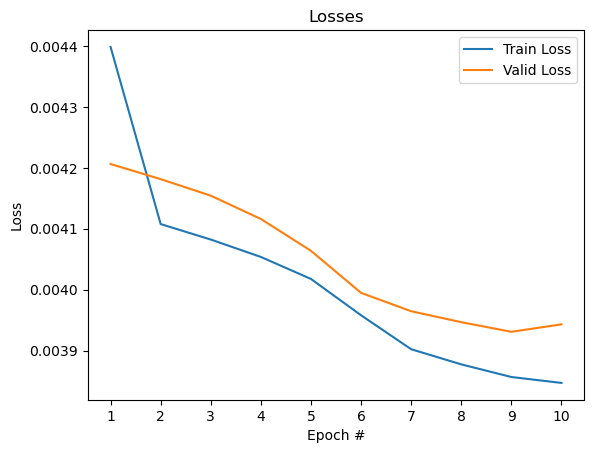

In [45]:
from matplotlib import pyplot as plt

epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [17]:
torch.save(model.state_dict(), "lstm_model.pth")

In [31]:
model = TextClassificationModel(
    output_size=13,  # two classes: positive vs. negative
    hidden_size=hidden_size,
    embedding_dimension=embedding_dimension,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<pad>'],
    dropout_probability=dropout_probability,
    bidirectional=is_bidirectional,
    n_layers=n_rnn_layers,
    device=device,
    batch_size=batch_size,
)
model.load_state_dict(torch.load("lstm_model.pth"))
model.eval()

/var/folders/04/yrfsznxd5_vc4gxsmntwjt8r0000gn/T/ipykernel_45131/2370253864.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lstm_model

FileNotFoundError: [Errno 2] No such file or directory: 'lstm_model.pth'

In [58]:
from sklearn.metrics import classification_report
import numpy as np

model.eval()
test_accuracy = n_examples = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, target, text in tqdm(test_loader, leave=False):
        target = target.to(device)

        _, logits = model(inputs, return_activations=True)

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[ 366,  266,  773,  ...,  915,   45,  842],
        [ 180,  822,  774,  ...,  783,   45,   45],
        [  45,  723,  143,  ...,  463,   47,  953],
        ...,
        [ 815,  529,  821,  ..., 1001, 1001, 1001],
        [ 343,   45,  517,  ..., 1001, 1001, 1001],
        [ 966,  966, 1001,  ..., 1001, 1001, 1001]])
tensor([[[ 0.9660,  0.2466, -0.5464,  ..., -1.4728, -0.0170, -0.1870],
         [-0.5151, -0.5731, -0.4868,  ...,  1.2267,  0.0449,  0.1171],
         [-0.0696,  1.0108, -0.7915,  ...,  0.3471, -0.2649, -0.6014],
         ...,
         [ 1.9378, -0.2163, -1.3722,  ...,  1.6312,  2.3130, -2.3587],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537],
         [ 0.7575,  0.6808,  1.0330,  ...,  0.4201,  1.3480, -2.5223]],

        [[-0.7000, -0.8110, -1.0252,  ..., -0.1010,  0.0350,  0.5547],
         [-0.1484,  0.7462,  0.9866,  ..., -0.6239,  0.0903,  0.7766],
         [ 0.3483,  0.1080, -0.5864,  ...,  1.2636, -0.1586, -0.6150],
         ...,
     

/Users/rlopes/miniconda3/envs/is/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rlopes/miniconda3/envs/is/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rlopes/miniconda3/envs/is/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
import random
from ipywidgets import HTML

flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, target_lst, text_lst = zip(*test_loader)
inputs_lst, target_lst, text_lst = map(flatten, [inputs_lst, target_lst, text_lst])
test_examples = list(zip(inputs_lst, target_lst, text_lst))


def print_random_prediction(n=10):
    to_emoji = lambda y1, y2: '😄' if y1 == y2 else '😡'
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, target, text = random.choice(test_examples)
            target = target.item()

            _, logits = model([inputs], return_activations=True)
            logits = logits.detach().cpu().numpy()
            prediction = np.argmax(logits, axis=1)[0]

            predicted = to_emoji(target, prediction)

            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{unique[prediction]} == {unique[target]}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
<table>
<tbody>
<tr>
<td><b>Review</b>&nbsp;</td>
<td><b>Predicted</b>&nbsp;</td>
<td><b>Actual</b>&nbsp;</td>
</tr>
{rows_joined}
</tbody>
</table>
"""
    display(HTML(table))

In [61]:
print_random_prediction(10)

tensor([[ 244,   45,  143,  829,  915,  919,  405,   45,  993,  765,  140,   85,
         1000,  764,   45]])
tensor([[[-0.0908,  0.1099,  0.3184,  ...,  0.0758,  0.9385, -0.7371],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537],
         [ 0.9744, -1.1733,  0.2189,  ...,  0.0186,  0.1697, -1.8631],
         ...,
         [ 1.1877,  1.0164,  0.8558,  ...,  1.1655, -0.7784, -0.1015],
         [ 0.4948,  1.0173, -0.9312,  ..., -1.1180,  0.1065, -1.1160],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537]]])
tensor([[319, 973, 815, 266, 771, 463,  45, 576,  45, 404]])
tensor([[[-0.2306,  0.9798,  1.8216,  ...,  1.0044,  0.7435,  0.2145],
         [ 0.4222, -1.2051,  0.6399,  ..., -0.3388, -0.2540,  0.3721],
         [ 0.4588, -0.9987, -0.2228,  ..., -0.2245, -0.1353, -1.1859],
         ...,
         [ 0.7227,  0.2920,  0.2990,  ...,  0.6091,  0.3135, -0.6840],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537],
         [ 0.1322,

HTML(value='\n<table>\n<tbody>\n<tr>\n<td><b>Review</b>&nbsp;</td>\n<td><b>Predicted</b>&nbsp;</td>\n<td><b>Ac…